<a href="https://colab.research.google.com/github/iwatobipen/playground/blob/master/mishimasyk_handson_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
!mkdir ./img
!wget http://jamesrobertlloyd.com/images/neural-art/style/picasso-face.jpg -P ./img
!wget http://jamesrobertlloyd.com/images/neural-art/content/eiffel-tower-1.jpg -P ./img
!wget https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg -P ./img
from keras.preprocessing.image import load_img, img_to_array
target_path = './img/eiffel-tower-1.jpg'
#style_reference_image_path = './img/picasso-face.jpg'
style_reference_image_path = './img/The_Great_Wave_off_Kanagawa.jpg'

width, height = load_img(target_path).size
img_height = 400
img_width = int(width * img_height/ height)


mkdir: cannot create directory ‘./img’: File exists
--2019-01-03 12:06:45--  http://jamesrobertlloyd.com/images/neural-art/style/picasso-face.jpg
Resolving jamesrobertlloyd.com (jamesrobertlloyd.com)... 192.30.252.153, 192.30.252.154
Connecting to jamesrobertlloyd.com (jamesrobertlloyd.com)|192.30.252.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15556 (15K) [image/jpeg]
Saving to: ‘./img/picasso-face.jpg.1’

picasso-face.jpg.1  100%[===================>]  15.19K  84.3KB/s    in 0.2s    

2019-01-03 12:06:46 (84.3 KB/s) - ‘./img/picasso-face.jpg.1’ saved [15556/15556]

--2019-01-03 12:06:47--  http://jamesrobertlloyd.com/images/neural-art/content/eiffel-tower-1.jpg
Resolving jamesrobertlloyd.com (jamesrobertlloyd.com)... 192.30.252.153, 192.30.252.154
Connecting to jamesrobertlloyd.com (jamesrobertlloyd.com)|192.30.252.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75286 (74K) [image/jpeg]
Saving to: ‘./img/eiffel-tower-1.jpg

In [0]:
import numpy as np
from keras.applications import vgg19

In [0]:
def preprocess_image(image_path):
  img = load_img(image_path, target_size=(img_height, img_width))
  img = img_to_array(img)
  #print(img.shape)
  img = np.expand_dims(img, axis=0)
  #print(img.shape)
  img = vgg19.preprocess_input(img)
  #print(img.shape)
  return img

In [0]:
def deprocess_image(x):
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [0]:
from keras import backend as K
target_image = K.constant(preprocess_image(target_path))
style_reference_image =  K.constant(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, img_height, img_width, 3))
input_tensor = K.concatenate([target_image, style_reference_image, combination_image], axis=0)

In [0]:
model = vgg19.VGG19( input_tensor=input_tensor,
                     weights='imagenet',
                     include_top=False)

In [0]:
#model.summary()

In [0]:
def content_loss(base, combination):
  return K.sum(K.square(combination-base))

def gram_matrix(x):
  features = K.batch_flatten( K.permute_dimensions(x,(2, 0, 1)))
  gram = K.dot(features, K.transpose(features))
  return gram

def style_loss(style, combination):
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = img_height * img_width
  return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [0]:
def total_varidation_loss(x):
  a = K.square(
      x[:, :img_height - 1, :img_width - 1, :] - 
      x[:, 1:, :img_width - 1, :])
  b = K.square(
      x[:, :img_height - 1, :img_width - 1, :] - 
      x[:, :img_height - 1, 1:, :])
  return K.sum(K.pow(a + b, 1.25))

In [0]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
content_layer = 'block5_conv2'
style_layers = [
                'block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
             ]
total_validation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

In [0]:
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features, combination_features)

In [0]:
for layer_name in style_layers:
  layer_features = outputs_dict[layer_name]
  style_reference_features = layer_features[1, :, :, :]
  combination_features = layer_features[2, :, :, :]
  sl = style_loss(style_reference_features, combination_features)
  loss += (style_weight / len( style_layers)) * sl
loss += total_validation_weight * total_varidation_loss(combination_image)

In [0]:
grads = K.gradients(loss, combination_image)[0]
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


In [0]:
class Evaluator(object):
  
  def __init__(self):
    self.loss_value = None
    self.grads_values = None
  
  def loss(self, x):
    assert self.loss_value is None
    x = x.reshape((1, img_height, img_width, 3))
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    self.loss_value = loss_value
    self.grad_values = grad_values
    return self.loss_value

  def grads(self, x):
    assert self.loss_value is not None
    grad_values = np.copy(self.grad_values)
    self.loss_value = None
    self.grad_values = None
    return grad_values

In [52]:
evaluator = Evaluator()
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time
result_prefix = 'my_result'
iterations = 20
x = preprocess_image(target_path)
x = x.flatten()
for i in range(iterations):
  print(i)
  start_time = time.time()
  x, min_val, info = fmin_l_bfgs_b(evaluator.loss,
                                  x,
                                  fprime=evaluator.grads,
                                  maxfun=20)
  print('current loss value {}'.format(min_val))
  img = x.copy().reshape((img_height, img_width, 3))
  img = deprocess_image(img)
  fname = result_prefix + '_at_iteration_{}_th.png'.format(i)
  imsave(fname, img)
  end_time = time.time()
  print('iteration {} completed in {}'.format(i, end_time-start_time))

0
current loss value 3522878976.0
iteration 0 completed in 17.595162391662598
1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


current loss value 1487837184.0
iteration 1 completed in 16.93233370780945
2
current loss value 941473216.0
iteration 2 completed in 16.953893661499023
3
current loss value 677570752.0
iteration 3 completed in 17.683490753173828
4
current loss value 531509440.0
iteration 4 completed in 17.01197338104248
5
current loss value 447209760.0
iteration 5 completed in 17.0399169921875
6
current loss value 377698272.0
iteration 6 completed in 17.11442732810974
7
current loss value 333387904.0
iteration 7 completed in 17.06341242790222
8
current loss value 298563264.0
iteration 8 completed in 17.12944483757019
9
current loss value 273929792.0
iteration 9 completed in 17.03501534461975
10
current loss value 253101104.0
iteration 10 completed in 17.151625633239746
11
current loss value 237747472.0
iteration 11 completed in 17.057376623153687
12
current loss value 222797456.0
iteration 12 completed in 17.034810781478882
13
current loss value 210114992.0
iteration 13 completed in 17.051005125045776


In [53]:
!ls

img				  my_result_at_iteration_19_th.png
my_result_at_iteration_0_th.png   my_result_at_iteration_1_th.png
my_result_at_iteration_10_th.png  my_result_at_iteration_2_th.png
my_result_at_iteration_11_th.png  my_result_at_iteration_3_th.png
my_result_at_iteration_12_th.png  my_result_at_iteration_4_th.png
my_result_at_iteration_13_th.png  my_result_at_iteration_5_th.png
my_result_at_iteration_14_th.png  my_result_at_iteration_6_th.png
my_result_at_iteration_15_th.png  my_result_at_iteration_7_th.png
my_result_at_iteration_16_th.png  my_result_at_iteration_8_th.png
my_result_at_iteration_17_th.png  my_result_at_iteration_9_th.png
my_result_at_iteration_18_th.png  sample_data


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
style_img = Image.open('./img/picasso-face.jpg')
style_img = Image.open('./img/The_Great_Wave_off_Kanagawa.jpg')

style_img = np.asarray(style_img)
target_img = Image.open(target_path)
target_img = np.asarray(target_img)

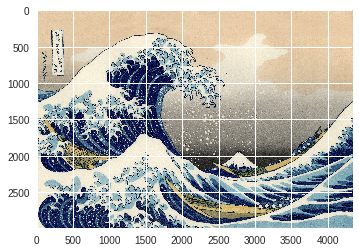

In [60]:
plt.imshow(style_img)

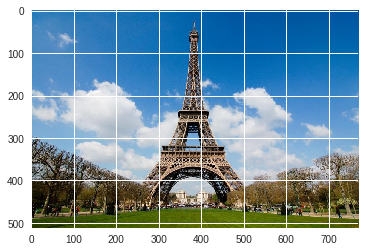

In [61]:
plt.imshow(target_img)

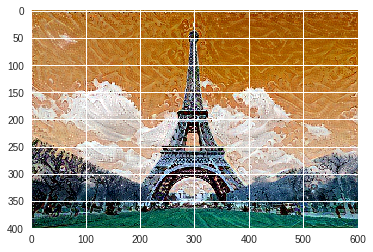

In [62]:
img = Image.open('./my_result_at_iteration_0_th.png')
img = np.asarray(img)
plt.imshow(img)

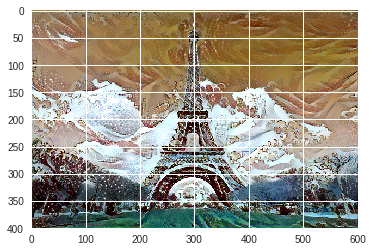

In [63]:
img = Image.open('./my_result_at_iteration_18_th.png')
img = np.asarray(img)
plt.imshow(img)